## Trend Analysis and forecasting with Prophet

In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use("seaborn-whitegrid")

from IPython.display import display

from src.data_matching import match_data
from src.get_data import get_madrid_data, get_weather_df, get_air_quality_df, get_traffic_df
from src.models.train_model import train_prophet_model, train_clasp_model
from src.models.trend_analysis import get_trend_deviation_from_changepoint
from src.visualization import visualize_prophet_results, visualize_clasp_results
import os, logging
from itertools import product

from src.models.prophet_utils import get_changepoints_from_model, make_metrics_from_prophet_results

%matplotlib inline
pd.options.plotting.backend = "plotly"

# set matplotlib style
plt.style.use("seaborn-whitegrid")
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'white'

logging.getLogger('prophet').setLevel(logging.WARNING)
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
aq_df = get_air_quality_df("../01-data")
aq_df.columns = aq_df.columns.str.replace("µ","u")
weather_df = get_weather_df("../01-data").dropna()
predict_df = match_data(aq_df, weather_df)

predict_df = predict_df.set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()

In [10]:
# zone = 3
# pollutant = "no2_ug_m3"
# changepoint_to_analyze = "2020-03-10"
# #eval_delta a 20 days y change points "2016-12-24" y "2016-10-27"
zone = 1
pollutant = "no2_ug_m3"
changepoint_to_analyze = "2016-12-24"

deviation_percent_pre,deviation_percent_post = get_trend_deviation_from_changepoint(
    normalized_predict_df,
    pollutant=pollutant,
    location=zone,
    changepoint=changepoint_to_analyze,    
    eval_delta=pd.Timedelta(days=20),
    eval_start = pd.Timedelta(days=45),
    pretrend_start = pd.Timedelta(days=180),
    start=None,
    title=f"Forecast and trend of meteorologically-normalized {pollutant.split('_')[0].upper()} on Zone {zone}",
    # changepoint_range=0.9,
    # **prophet_paramss
)
print(f"Predicted trend of {pollutant.split('_')[0].upper()} is on average {deviation_percent_pre:+.2%} away from the real trend "\
    f"before the changepoint and {deviation_percent_post:+.2%} after the changepoint")

NameError: name 'normalized_predict_df' is not defined

The same can be done with the meteorologically normalized time series 

In [77]:
normalized_aq_df = get_air_quality_df("../01-data",meteo_normalized=True)
normalized_aq_df.columns = normalized_aq_df.columns.str.replace("µ","u")

normalized_aq_df = normalized_aq_df.set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()

In [13]:
normalized_aq_df = get_air_quality_df("../01-data",meteo_normalized=True)
normalized_aq_df.columns = normalized_aq_df.columns.str.replace("µ","u")

normalized_aq_df = normalized_aq_df.set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()

Predicted trend of NO2 is on average +0.30% away from the real trend before the changepoint and +2.63% after the changepoint


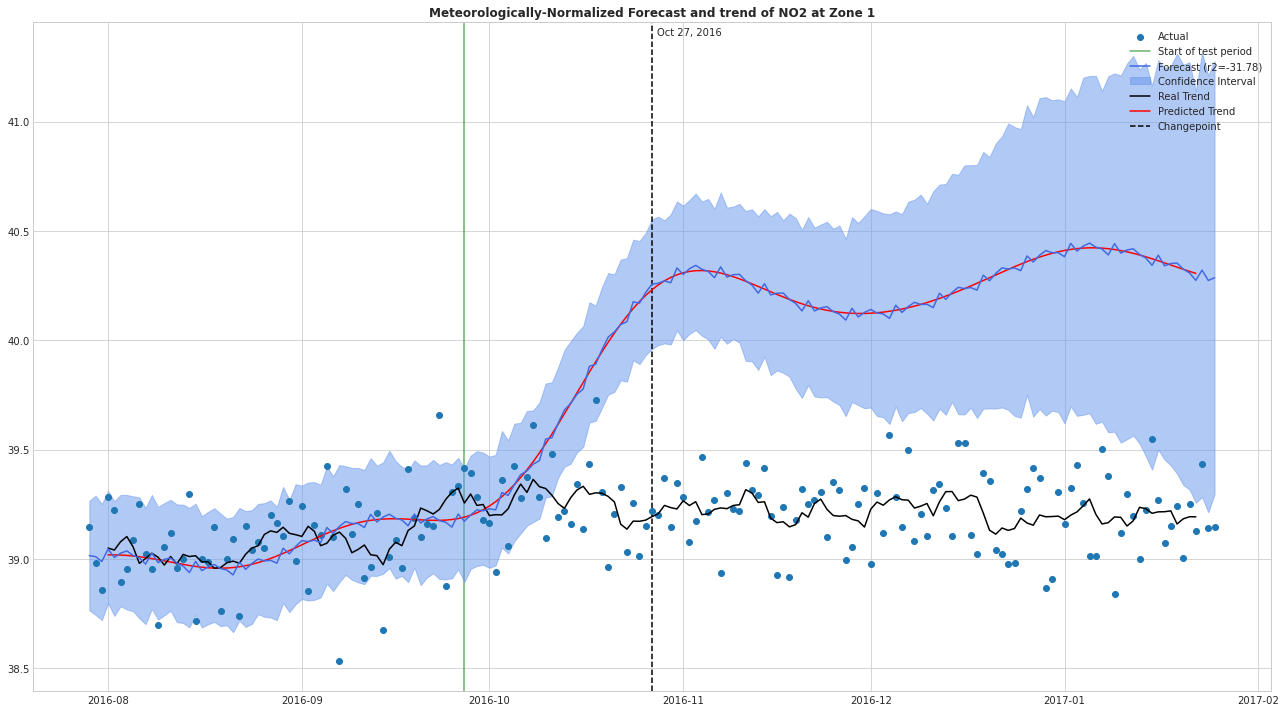

In [15]:
zone = 1
pollutant = "no2_ug_m3"
changepoint_to_analyze = "2016-10-27"
location_by = "zone"

deviation_percent_pre,deviation_percent_post = get_trend_deviation_from_changepoint(
    normalized_aq_df,
    pollutant=pollutant,
    location=zone,
    start="2010-01-01",
    end="2021-11-01",
    changepoint=changepoint_to_analyze,    
    eval_delta=pd.Timedelta(days=90),
    eval_start=pd.Timedelta(days=30),
    pretrend_start = pd.Timedelta(days=60),
    title = f"Meteorologically-Normalized Forecast and trend of {pollutant.split('_')[0].upper()} at {location_by.capitalize()} {zone}"
)
print(f"Predicted trend of {pollutant.split('_')[0].upper()} is on average {deviation_percent_pre:+.2%} away from the real trend "\
    f"before the changepoint and {deviation_percent_post:+.2%} after the changepoint")

--------

Extract changepoints and train a prophet model that predicts 3 months ahead in the future

In [20]:
# Training parameters

start = "2010-01-01"
end = "2020-10-30"
indicator = "no2_ug_m3"
location_by = "zone"

## ClaSP
n_changepoints = 3

## Prophet
eval_delta = pd.Timedelta(days=90)
changepoints_threshold = .75
prophet_model_params = {
    "changepoint_prior_scale": 0.4,
    "changepoint_range": 0.9,
    "seasonality_mode": "additive",
    "seasonality_prior_scale": 10,
    "holidays_prior_scale": 6,
}
savefigs = False # Save figures to disk

# Dataframe to use for training/predictions
df = madrid_df.loc[(madrid_df.time.between(start,end))]
result_metrics = [] # list to store metrics for each model/evaluation
for location in df[location_by].unique():
    # Train clasp and get the changepoints
    clasp_results = train_clasp_model(
        df,
        y=indicator,
        location=location,
        location_by=location_by,
        n_changepoints=n_changepoints,
        train_start=start,
        train_end=end,
        verbose=False
    )
    changepoints_df = clasp_results.changepoints_df
    changepoints = changepoints_df.time.values
    location_df = df[(df[location_by]==location)]
    for cp in changepoints:
        if np.abs(cp-df.time.min()).days < 30:
            continue
        results = train_prophet_model(
                    location_df, indicator,
                    eval_start=cp,
                    eval_end = cp+eval_delta,
                    verbose=False,
                    **prophet_model_params
        )
        fig, axes = visualize_prophet_results(
            results,changepoints_threshold=changepoints_threshold,
            ax_titles=[
                f"Actual recorded values of {indicator} for {location_by} {location}",
                f"Changepoints and Forecast of {indicator} for {location_by} {location} from {pd.to_datetime(cp).strftime('%b-%d-%Y')} to {(cp+eval_delta).strftime('%b-%d-%Y')}"
            ],
            nrows=2
        )
        metrics = make_metrics_from_prophet_results(results,changepoints_threshold)
        result_metrics.append({"indicator": indicator,"location": location,"eval_start":cp,"eval_end":cp+eval_delta,**metrics})
        if savefigs:
            # Save figure to disk
            start_str = pd.to_datetime(start).strftime("%Y.%-m.%-d")
            plt.savefig(f"../reports/figures/prophet/prophet_forecast_{start_str}_{indicator}_{location.lower().replace(' ','_')}.png")
            fig.show()
results_df = pd.DataFrame(result_metrics)

In [ ]:
results_df.to_csv("../reports/prophet_results.csv",index=False)

Now with the un-normalized data

In [ ]:
# Training parameters

start = "2010-01-01"
end = "2020-10-30"
indicator = "no2_ug_m3"
location_by = "zone"

## ClaSP
n_changepoints = 4

## Prophet
eval_delta = pd.Timedelta(days=90)
changepoints_threshold = .75
prophet_model_params = {
    "changepoint_prior_scale": 0.4,
    "changepoint_range": 0.9,
    "seasonality_mode": "additive",
    "seasonality_prior_scale": 10,
    "holidays_prior_scale": 6,
}
savefigs = False # Save figures to disk

# Dataframe to use for training/predictions
df = madrid_df.loc[(madrid_df.time.between(start,end))]
result_metrics = [] # list to store metrics for each model/evaluation
for location in df[location_by].unique():
    # Train clasp and get the changepoints
    clasp_results = train_clasp_model(
        df,
        y=indicator,
        location=location,
        location_by=location_by,
        n_changepoints=n_changepoints,
        train_start=start,
        train_end=end,
        verbose=False
    )
    changepoints_df = clasp_results.changepoints_df
    changepoints = changepoints_df.time.values
    location_df = df[(df[location_by]==location)]
    for cp in changepoints:
        results = train_prophet_model(
                    location_df, indicator,
                    test_start=cp,
                    test_end = cp+eval_delta,
                    verbose=False,
                    **prophet_model_params
        )
        fig, axes = visualize_prophet_results(
            results,changepoints_threshold=changepoints_threshold,
            ax_titles=[
                f"Actual recorded values of {indicator} for {location_by} {location}",
                f"Changepoints and Forecast of {indicator} for {location_by} {location} from {pd.to_datetime(cp).strftime('%b-%d-%Y')} to {(cp+eval_delta).strftime('%b-%d-%Y')}"
            ],
            nrows=2
        )
        metrics = make_metrics_from_prophet_results(results,changepoints_threshold)
        result_metrics.append({"indicator": indicator,"location": location,"eval_start":cp,"eval_end":cp+eval_delta,**metrics})
        if savefigs:
            # Save figure to disk
            start_str = pd.to_datetime(start).strftime("%Y.%-m.%-d")
            plt.savefig(f"../reports/figures/prophet/prophet_forecast_{start_str}_{indicator}_{location.lower().replace(' ','_')}.png")
            fig.show()
results_df = pd.DataFrame(result_metrics)

In [ ]:
display(results.eval_metrics_df)
percent_diff = (results.eval_metrics_df.mean_diff.score/results.test_df.y.mean())*100
print("The prediction was on average {:+.2f}%% off".format(percent_diff))

,mse,mae,r2,mean_diff
score,105.937276,7.90801,0.457057,2.412873


The prediction was on average +9.12%% off


In [ ]:
# Inspect model betas
m = results.model
component_cols = m.train_component_cols.columns
regressor_cols_inds = range(len(component_cols)-20,len(component_cols)) #np.where(component_cols.columns.isin(weather_df.columns.drop("time")))[0]
regressor_betas = m.params["beta"][0,regressor_cols_inds]
print("\n".join(f"{col}: {beta:.3f}" for col,beta in zip(component_cols[regressor_cols_inds],regressor_betas)))